### Fast Paillier

#### Introduction to the Paillier Cryptosystem
The Paillier cryptosystem is an probabilistic asymmetric algorithm for public key cryptography, designed in 1999 by Pascal Paillier. 

This cryptosystem has the important property that it is homomorphic in its addition operator. Explicitly, if $\alpha$, $\beta$, and $\xi$ are scalars, $a$ and $b$ are two plaintexts, and $Enc(a)$, $Enc(b)$ are the encryption of $a$ and $b$ under the same public key, then $D(\alpha E(a) + \beta E(b) + \xi) = \alpha D(E(a)) + \beta D(E(b)) + \xi$ where $D$ is the decryption under the secret key. This means that operations of scalar multiplication, scalar addition, and element-wise addition in the ciphertext-space are preserved in the message-space after encryption.

This means that an untrusted third party could perform a limited set of computations on the encrypted data without ever finding out what the data is. For example, Alice could generate a key pair $(p, s)$ and send Bob a list of numbers $X = [x_1, x_2, \ldots, x_n]$ encrypted under her public key, $E_p(X) = [E_p(x_1), E_p(x_2), \ldots, E_p(x_n)]$. She could then ask Bob to take the mean of these numbers and return the result $S = \frac{1}{n} \sum_{i = 1}^n E_p(x_i)$. Bob learned nothing about the $X$ from doing this, but given $S$, Alice could compute $D_s(S) = D_s(\frac{1}{n}\sum_{i=1}^nE_p(x_i)) = \frac{1}{n}\sum_{i=1}^nD_s(E_p(x_i)) = \frac{1}{n}\sum_{i=1}^n x_i$ and obtain the correct mean value.

#### Vector Operations with Paillier
Suppose $x \in \mathbb{Z}^D$ is a $D$-dimensional vector. We can extend the Paillier cryptosystem to do some structure preserving operations on vectors.

Suppose again Alice has a key pair $(p, s)$. If $\vec{x} = [x_1, x_2, \ldots, x_D]^T$, we can define $E_p(\vec{x}) = [E_p(x_1), E_p(x_2), \ldots, E_p(x_D)]^T$. With this definition, we can perform similar operations to those described in the indroduction on vectors instead of values in $\mathbb{R}$. For example, if $X = \big( \, \vec{x_1} \big| \vec{x_2} \big| \ldots \big| \vec{x_n} \, \big)$ is a matrix in $\mathbb{R}^{D \times n}$, Alice can encrypt this entire matrix by encrypting each vector individually. Then Alice can send the encrypted matrix $E_p(X) = \big( \, E_p(\vec{x_1}) \big| E_p(\vec{x_2}) \big| \ldots \big| E_p(\vec{x_n}) \, \big)$ to Bob and have him compute the row-wise mean $E_p(\vec{\mu}) = \frac{1}{n}\sum_{i = 1}^n E_p(\vec{x}_i)$. Finally, Alice can decrypt $D_s(E_p(\vec{\mu})) = \vec{\mu}$ to get the result.

#### Inefficiencies with Small Messages
The encryption operation $E_p(m)$ in the Paillier cryptosystem is explicitely $E_p(m) = g^m r^n \mod n^2$ where $g \in \mathbb{Z}_{n^2}^*$ and $r \in \mathbb{Z}$ is a random number.

Since the secret key $s$ is easy to compute with the factorization of $N = pq$, like in RSA, we must choose large moduli (e.g. N = 2048 bits) to avoid brute force factoring attacks. But according to the original paper, the Paillier cryptosystem is safe to use with plaintexts $m \in \mathbb{Z}^{\frac{N}{3} - 1}$. This leads to major inefficiencies in some specific use cases. Here is an example of the problem:

Suppose Alice now has a matrix $M \in \{0, 1\}^{\{D, n\}}$ where $D >> n$ and $n << N$. This is a common setting in Genomic studies, where $D \approx 28e6$, $n \approx 100$, and $M_{i, j} = 1$ if subject $j$ has mutation $i$, else $0$.

If Alice wants to now find the the row sum of her data (the count of each mutation in the entire cohort of $n$ subjects), she will need to perform the expensive encryption operation on every entry in the matrix $M$ even though she only required $N$ to avoid brute force attacks and is not at all taking advantage of the fact that the encryption scheme works for values in $m \in \mathbb{Z}^{\frac{N}{3} - 1}$ (since the highest possible value she can have in her result is $100$).

Empirically, we can see the this is a large slow down.

In [1]:
from phe import paillier
import numpy as np
import sys
sys.path.append('..')
import gphe.vecphe as vphe
p, s = paillier.generate_paillier_keypair()
D, n = (128, 4)
M = np.random.binomial(1, .5, (D, n))
print("(D, n) =", (D, n))

(D, n) = (128, 4)


In [2]:
%%time
E_Mslow = vphe.matEnc(p, M)

CPU times: user 30.6 s, sys: 28 ms, total: 30.6 s
Wall time: 30.9 s


In [3]:
%%bash
screenfetch

                          ./+o+-       ryan@galliumos
                  yyyyy- -yyyyyy+      OS: Ubuntu 16.04 xenial
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 4.9.4-galliumos-braswell
           .++ .:/++++++/-.+sss/`      Uptime: 3h 48m
         .:++o:  /++++++++/:--:/-      Packages: 1830
        o:+o+:++.`..```.-/oo+++++/     Shell: bash 4.3.48
       .:+o:+o/.          `+sssoo+/    Resolution: 1920x1080
  .++/+:+oo+o:`             /sssooo.   DE: XFCE
 /+++//+:`oo+o               /::--:.   WM: Xfwm4
 \+/+o+++`o++o               ++////.   WM Theme: Arc-Darker-GalliumOS
  .++.o+++oo+:`             /dddhhh.   GTK Theme: Arc-GalliumOS [GTK2]
       .+.o+oo:.          `oddhhhh+    Icon Theme: Numix-Circle-GalliumOS
        \+.++o+o``-````.:ohdhhhhh+     Font: Roboto 10
         `:o+++ `ohhhhhhhhyo++os:      CPU: Intel Celeron CPU N3160 @ 1.601GHz
           .o:`.syhhhhhhh/.oo++o`      RAM: 1747MiB / 3900MiB
               /osyyyyyyo++ooo+++/    
                   `````

As you can see, the process of encrypting such a matrix where $D = 128$ and $n = 4$ (which is very small) takes 30 seconds. Even on better hardware (as you can see, we are not working with a powerhouse here), it is unlikely that a larger genomic study where $D$ is in the millions and $n$ is in the hundreds is going to finish any time soon.

#### Speeding Things Up
The reason this experiment went so poorly is because our data structure was not taking advantage of the large amount of numbers encrypted values could take on. We fix this as follows:

Consider the mapping $$f_{b, l}: \{0, 1\}^{\{D, n\}} \rightarrow \mathbb{Z}^{\{d, n\}}$$ parameterized by a base size variable $b$ and a block length variable $l$. We define $$g_{b}: \{0, 1\}^l \rightarrow \mathbb{Z}_b, \,\, g(\vec{x}) = \sum_{i = 0}^{l - 1} x_{i + 1} b^i$$  and $$z_{b, l}: \{0, 1\}^{l, n} \rightarrow \mathbb{Z}_b^n, \,\, z_b(M, i) = [g_{b}(M[i:i+l, 1]), g_{b}(M[i:i+l, 1]), \ldots, g_{b}(M[i:i+l, n])]$$.

We take $$f_{b, l}(M) = \bigg(z_{b, l}(M, 0)^T, z_{b, l}(M, l)^T, \ldots, z_{b, l}(M, \frac{n}{l})^T  \bigg)^T$$

The point here is that $f$ is an isomorphism since $g$ is invertible, but $d << D$.

We test this experiment with:
* $b = 128$
* $l = 128$
* $D = 128$
* $n = 4$
* $d = 4$

In [4]:
%%time
E_Mfast = vphe.fmatEnc(p, M)

CPU times: user 1.13 s, sys: 29 ms, total: 1.15 s
Wall time: 1.21 s


As we can see, this new encryption scheme ran much faster at at over a 1000x speedup. Decryption time is also improved with this scheme, as we can see below.

In [5]:
%%time
Mslow = vphe.matDec(s, E_Mslow)

CPU times: user 8.76 s, sys: 12 ms, total: 8.77 s
Wall time: 8.95 s


In [6]:
%%time
Mfast = vphe.fmatDec(s, E_Mfast)

CPU times: user 82 ms, sys: 1 ms, total: 83 ms
Wall time: 89.8 ms


We see a similar speedup of around 1000x. Now we check to see if the decrypted matrices are actually the same.

In [7]:
assert all( Mslow.flatten() == Mfast.flatten())

Now we run several tests to see how the Encryption plus Decryption times very as a function of the number of points in the matrix for the Fast and Slow schemes. We plot the results below.

In [8]:
import time
Ds = [2**x for x in range(1, 6)]
ns = [10 * x for x in range(1, 6)]
slowtimes = []
fasttimes = []
numpoints = []
for D, n in zip(Ds, ns):
    numpoints.append(D * n)
    M = np.random.binomial(1, .5, (D, n))
    
    start = time.time()
    E_Mslow = vphe.matEnc(p, M)
    Mslow = vphe.matDec(s, E_Mslow)
    end = time.time()
    slowtimes.append(end - start)
    
    start = time.time()
    E_Mfast = vphe.fmatEnc(p, M)
    Mfast = vphe.fmatDec(s, E_Mfast)
    end = time.time()
    fasttimes.append(end - start)

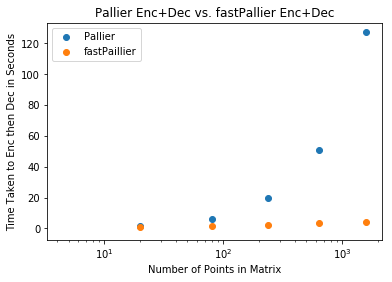

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(numpoints, slowtimes, label="Pallier")
plt.scatter(numpoints, fasttimes, label="fastPaillier")
plt.xlabel("Number of Points in Matrix")
plt.ylabel("Time Taken to Enc then Dec in Seconds")
plt.xscale("log")
plt.title("Pallier Enc+Dec vs. fastPallier Enc+Dec")
plt.legend()
plt.show()

We see that the fastPaillier schemes is performing much better than the normal Paillier scheme. We continue the fastPaillier plot since it is not prohibatively long, and see the general trend of the fast scheme.

In [10]:
Ds = [2**x for x in range(6, 12)]
ns = [10 * x for x in range(6, 12)]
for D, n in zip(Ds, ns):
    numpoints.append(D * n)
    M = np.random.binomial(1, .5, (D, n))
    
    start = time.time()
    E_Mfast = vphe.fmatEnc(p, M)
    Mfast = vphe.fmatDec(s, E_Mfast)
    end = time.time()
    fasttimes.append(end - start)

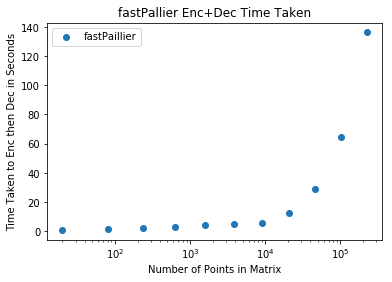

In [11]:
plt.scatter(numpoints, fasttimes, label="fastPaillier")
plt.xlabel("Number of Points in Matrix")
plt.ylabel("Time Taken to Enc then Dec in Seconds")
plt.xscale("log")
plt.title("fastPallier Enc+Dec Time Taken")
plt.legend()
plt.show()